Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Piotr Szuba"

---

# Bayesowskie Sieci Neuronowe (ang. *Bayesian Neural Networks*)

BSN (Bayesowskie Sieci Neuronowe) są rozszerzeniem tradycyjnych sieci neuronowych o elementy wnioskowania i uczenia Bayesowskiego. Wśród zalet tych sieci możemy wskazać:
- możliwość pomiaru niepewności modelu (*uncertainty*) dla predykcji (przy różnych poziomach pewności - ang. *confidence levels*)
- istnieje możliwość zakodowanie wiedzy apriori na temat rozkładu wag sieci

## Podejście Bayesowskie

W przypadku zwykłych sieci neuronowych parametry (wagi) sieci estymujemy metodą Maximum Likelihood, która maksymalizuje prawdopodobieństwo obserwowania danych $\mathcal{D}$ pod warunkiem parametrów $\mathbf{w}$:

$$
\text{arg max}_\theta p(\mathcal{D}|\mathbf{w})
$$

Skutkiem tego jest punktowa estymata parametrów, która nie pozwala modelować niepewności. Możemy jednak wykorzystać twierdzenie Bayesa i przekształcić problem do **uczenia rozkładu parametrów modelu**: 

$$
p(\mathbf{w} | \mathcal{D}) = \frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})}{p(\mathcal{D})}
$$

W ten sposób opisujemy rozkład posteriora, gdzie $p(\mathbf{w})$ to wiedza apriori na temat parametrów (wag) modelu. Używając wnioskowania Bayesowskiego, możemy uzyskać predykcje modelu obliczając całkę po całej przestrzeni parametrów $\mathbf{w}$:


$$
p(y | x, \mathcal{D}) = \int p(y | x,\mathbf{w}) p(\mathbf{w} | \mathcal{D})\, d\mathbf{w}
$$

Oczywiście taka całka jest praktycznie nie możliwa do policzenia - z jednej strony mamy nieskończenie wiele możliwych wartości parametrów, a ponadto nie znamy rozkładu danych.

W literaturze zaproponowano kilka możliwych aproksymacji tego problemu:
- jedną z nich jest [Stochastic Variational Inference](http://jmlr.org/papers/v14/hoffman13a.html) (2014) **i na niej skupimy się w tym zeszycie**
- Monte Carlo Markov Chain (MCMC)


Alternatywnie zamiast aproksymować rozkład predykcyjny możemy zaproksymować całą Bayesowską sieć neuronową -- np. za pomocą mechanizmu Dropout, w postaci metody Monte Carlo Dropout: [Yarin Gal and Zoubin Ghahramani in "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning"](https://arxiv.org/abs/1506.02142)

## Variational inference

Na początku chcielibyśmy policzyć rozkład posterior parametrów $p(\mathbf{w}|\mathcal{D})$. Nie znamy tego rozkładu ani nie jesteśmy w stanie policzyć rozkładu danych $p(\mathcal{D})$. Możemy jednak wykorzystać mechanizm Variational Inference. Określamy rozkład wariacyjny (ang. *variational distribution*), który pochodzi z rodziny znanych nam rozkładów (np. rozkład normalny) i powinien aproksymować skomplikowany nieznany nam rozkład. W poniższych wyprowadzeniach będziemy rozważać gausowski rozkład wariacyjny:

$$
q_\theta(\mathbf{w}) \approx p(\mathbf{w} | \mathcal{D})
$$

$\theta$ to parametry rozkładu wariacyjnego. W celu pomiaru jak dobrze rozkład wariacyjny aproksymuje ten pożądany (rzeczywisty) rozkład musimy określić pewną miarę odległości. Wykorzystamy dywergencję Kullbacka-Leiblera. Podczas optymalizacji problemu, będziemy poszukiwać optymalnych (najlepszych) parametrów rozkładu wariacyjnego, które minimalizują dywergencję KL:

$$
\theta_{opt} = \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w}) || p(\mathbf{w}|\mathcal{D}) \right]
$$

Dywergencja Kullbacka-Leiblera jest określona w następujący sposób:

$$
\text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] = \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w}|\mathcal{D})}\, d\mathbf{w}
$$

Aby policzyć tę całkę musimy znać rozkład posteriora $p(\mathbf{w}|\mathcal{D})$, dlatego stosujemy następujące przekształcenie:


$$
\begin{align}
\theta_{opt} &= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w} | \mathcal{D}) \right] \\
&= \text{arg min}_\theta \int q_\theta(\mathbf{w}) \log\frac{q_\theta(\mathbf{w})}{p(\mathbf{w})p(\mathcal{D}|\mathbf{w})}\, d\mathbf{w}\\
&= \text{arg min}_\theta \text{KL}\left[q_\theta(\mathbf{w})||p(\mathbf{w}) \right] - {\mathbb{E}}_{q_\theta(\mathbf{w})}\left[log p(\mathcal{D}|\mathbf{w})\right]
\end{align}
$$

Tę wartość nazywamy [Evidence Lower Bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound)

Aby uzyskać nieobciążone estymatory gradientów ELBO możemy zastosować estymację Monte Carlo losując wagi modelu $N$-krotnie i sumując wyniki kilku takich losowań. Podsumowując, optymalne wagi znajdujemy w następujący sposób:

$$\tag{1}
\theta_{opt} = \text{arg min}_\theta \frac{1}{N}\sum^N_{i=1} \log q_\theta(\mathbf{w}^{(i)}) - \log p(\mathbf{w}^{(i)}) - \log p(\mathcal{D}|\mathbf{w}^{(i)})
$$

gdzie $\mathbf{w}^{(i)}$ jest próbkowane z rozkładu $q_\theta(\mathbf{w})$. Zauważ, że ostatni człon $\log p(\mathcal{D}|\mathbf{w}^{(i)})$ to funkcja likelihood zwykłej sieci neuronowej.

## Sztuczka z reparametryzacją (ang. *reparametrization trick*)

Kolejnym problemem jest związanym z powyższą metodą jest brak możliwości obliczania pochodnych (brak różniczkowalności) w procesie optymalizacji parametrów sieci. Rozwiązaniem jest wykorzystanie sztuczki z reparametryzację (więcej szczegółów znajdziesz w [Variational Dropout and the Local Reparameterization Trick](https://arxiv.org/abs/1506.02557)). Zakładając, że chcemy wykorzystywać rozkład normalny, każdy wyuczalny parametr (waga) sieci $\theta$ będzie określony przez dwa inne parametry - średnią  $\mu$ oraz wariancję  $\sigma^2$ rozkładu normalnego:

$$
\theta = (\mu, \sigma^2)
$$

Używając sztuczki z reparametryzacją otrzymujemy:

$$
f(\epsilon) = \theta = \mu + \sigma \cdot \epsilon
$$

gdzie $\epsilon$ jest losowany z rozkładu normalnego standardowego:

$$
\epsilon \sim \mathcal{N}(0, 1)
$$

Jednym nieróżniczkowalnym członem jest $\epsilon$, jednak zależy nam głównie na parametrach $\mu$ oraz $\sigma$. Możemy policzyć gradienty w następujący sposób (w rzeczywistości biblioteki do uczenia sieci neuronowych obliczają te pochodne za nas):

$$
\begin{align}
    \Delta_\mu &= \frac{\partial f}{\partial \theta} + \frac{\partial f}{\partial \mu} \\
    \Delta_\sigma &= \frac{\partial f}{\partial \theta} \frac{\epsilon}{\sigma} + \frac{\partial f}{\partial \sigma}
\end{align}
$$

Parametry są aktualizowane w następujący sposób:

$$
\begin{align}
    \mu^{(t+1)} &= \mu^{t} - \alpha \Delta_\mu \\
    \sigma^{(t+1)} &= \sigma^t - \alpha \Delta_\sigma
\end{align}
$$

Tak zdefiniowane uczenie jest nazywane _Bayes by Backprop_ i jest kluczowym elementem Bayesowskich Sieci Neuronowych.

In [2]:
import torch
import torch.nn as nn
import math

# Prior

Poniższa implementacja bayesowskich sieci neuronowych jest oparta na pracy `https://arxiv.org/pdf/1505.05424.pdf`. Najpierw zaimplementujmy prior dla wag sieci. Wykorzystana będzie tutaj mikstura dwóch rozkładów normalnych. Implementacja ta jest zgodna z opisem w punkcie `3.3. Scale mixture prior` w przytoczonej publikacji.

In [3]:
class TwoGaussianMixturePrior:
    
    def __init__(
        self, 
        sigma_1: float = 1, 
        sigma_2: float = 1e-6, 
        mixing: float = 0.5,
    ):
        self.mixing = mixing
        
        self.w_prior_1 = torch.distributions.Normal(0, sigma_1)
        self.w_prior_2 = torch.distributions.Normal(0, sigma_2)
        
        self.b_prior_1 = torch.distributions.Normal(0, sigma_1)
        self.b_prior_2 = torch.distributions.Normal(0, sigma_2)
        
    def log_prob(self, weights: torch.Tensor, biases: torch.Tensor):
        w_log_prior_1 = self.w_prior_1.log_prob(weights).exp()
        w_log_prior_2 = self.w_prior_2.log_prob(weights).exp()
        
        w_prior = self.mixing * w_log_prior_1 + (1 - self.mixing) * w_log_prior_2
        
        b_log_prior_1 = self.b_prior_1.log_prob(biases).exp()
        b_log_prior_2 = self.b_prior_2.log_prob(biases).exp()
        
        b_prior = self.mixing * b_log_prior_1 + (1 - self.mixing) * b_log_prior_2
    
        # We don't want this log probability to depend on 
        # the actual number of network parameters (weights+biases),
        # so we compute the mean instead of a sum.
        return w_prior.log().mean() + b_prior.log().mean()

# Zadanie 1 (2 pkt) - Liniowa warstwa Bayesowska
Uzupełnij poniższą implementację bayesowskiej warstwy liniowej. Pamiętaj, że w omówionym podejściu wykorzystujemy rozkład normalny, a każda waga sieci jest określona przez parametry: $\mu$ oraz $\sigma^2$. 

- w funkcji `__init__()` zadeklaruj i zainicjuj wyuczalne parametry rozkładów normalnych, osobno dla wag sieci (`weight`) oraz obciążeń (`biases`)
- w funkcji `forward()` wylosuj wagi oraz obciążenia z przygotowanych rozkładów; użyj sztuczki z reparametryzacją; pamiętaj, że wariancja/odchylenie standardowe nie może być ujemne (zobacz rozdział: `3.2. Gaussian variational posterior` w podanej publikacji)
- w funkcji `variational_log_prob()` oblicz logarytm prawdopodobieństwa wariacyjnego $\log q_\phi(\theta^{(i)} | \mathcal{D}) $

In [4]:
class BayesianLinear(nn.Module):
    """Main reference: https://arxiv.org/pdf/1505.05424.pdf"""
    
    def __init__(
        self, 
        num_input_features: int,
        num_output_features: int,
        prior: TwoGaussianMixturePrior,
    ):
        """Implement initialization of weights and biases values"""
        super().__init__()
        
        self.prior = prior
        
        self.last_weights_ = None
        self.last_biases_ = None
        
        # Define weights parameters and initialize them using uniform distribution
        a = math.sqrt(2 / num_input_features) #Kaiming
        self.weight_mu = nn.Parameter(torch.Tensor(num_input_features, num_output_features).uniform_(-a, a))
        self.weight_rho = nn.Parameter(torch.Tensor(num_input_features, num_output_features).uniform_(-8, -7))
        
        # Define biases parameters and initialize them using uniform distribution
        self.bias_mu = nn.Parameter(torch.Tensor(num_output_features).uniform_(-a, a))
        self.bias_rho = nn.Parameter(torch.Tensor(num_output_features).uniform_(-8, -7))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Implement forward inference using reparametrization trick"""
        weight_std = torch.log1p(torch.exp(self.weight_rho))
        bias_std = torch.log1p(torch.exp(self.bias_rho))
        
        weight_epsilon = torch.randn_like(weight_std)
        bias_epsilon = torch.randn_like(bias_std)
        
        weights = self.weight_mu + weight_epsilon * weight_std
        biases = self.bias_mu + bias_epsilon * bias_std
        
        self.last_weights_ = weights
        self.last_biases_ = biases
        
        return x @ weights + biases
        
    def prior_log_prob(self) -> torch.Tensor:
        """Calculates the prior log prob of sampled weights and biases."""
        return self.prior.log_prob(weights=self.last_weights_, biases=self.last_biases_)
        
    def variational_log_prob(self) -> torch.Tensor:
        """Implement the variational log prob."""
        weight_var = torch.log1p(torch.exp(self.weight_rho)) ** 2
        bias_var = torch.log1p(torch.exp(self.bias_rho)) ** 2
        
        weight_distribution = torch.distributions.Normal(self.weight_mu, torch.sqrt(weight_var))
        bias_distribution = torch.distributions.Normal(self.bias_mu, torch.sqrt(bias_var))

        weight_prob = weight_distribution.log_prob(self.last_weights_)
        bias_prob = bias_distribution.log_prob(self.last_biases_)

        return weight_prob.sum() + bias_prob.sum()

### Bayesowski Wielowarstwowy Perceptron
Używając powyższej bayesowskiej wartstwy liniowej możemy zaimplementować bayesowską wersję wielowarstwowego perceptrona (ang. *MLP*). 

In [5]:
class BayesianMLP(nn.Module):
    def __init__(
        self, 
        num_input_features: int,
        num_hidden_features: int,
        num_output_classes: int,
    ):
        super().__init__()
        
        self.layer_1 = BayesianLinear(
            num_input_features, num_hidden_features, 
            prior=TwoGaussianMixturePrior(),
        )
        self.layer_2 = BayesianLinear(
            num_hidden_features, num_output_classes, 
            prior=TwoGaussianMixturePrior(),
        )
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.sigmoid(self.layer_1(x))
        x = self.softmax(self.layer_2(x))
        return x
        
    def prior_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.prior_log_prob()
        return log_prob
        
    def variational_log_prob(self) -> torch.Tensor:
        log_prob = 0
        for module in self.modules():
            if isinstance(module, BayesianLinear):
                log_prob += module.variational_log_prob()
        return log_prob

# Zadanie 2 (1.5 pkt) - ELBO dla `N` próbek Monte Carlo
Zaimplementuj liczenie ELBO korzystając ze wzoru $(1)$. Zastosuj funkcję kosztu `Negative Log Likelihood (NLL)` i pamiętaj, że w ten sposób człon: $- \log p(\mathcal{D}|\mathbf{w}^{(i)})$ będzie w pełni obliczany przez NLL (jego wartość należy dodać do łącznego kosztu, a nie odejmować!). Dodatkowo należy podkreślić, że log likelihood próbki danych to suma log likelihood'ów każdego z elementów zbioru.

In [10]:
from typing import Union, Tuple


class ELBO(nn.Module):
    def __init__(self, N: int):
        super().__init__()
        
        self.N = N
        self.nll = nn.NLLLoss(reduction="none")
    
    def forward(
        self, 
        model: nn.Module, 
        inputs: torch.Tensor,
        targets: torch.Tensor,
        *,
        return_predictions: bool = False,
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Calculate loss according to the equation (2) of https://arxiv.org/abs/1505.05424"""
        predictions = []
        log_posteriors = []
        log_priors = []
        nll_loss_sum = 0
        
        for _ in range(self.N):
            preds = model(inputs)
            predictions.append(preds)
            
            log_posteriors.append(model.variational_log_prob())
            log_priors.append(model.prior_log_prob())
            
            targets_max = torch.argmax(targets, dim=1)
            nll_loss_sum += torch.sum(self.nll(preds, targets_max))
            
        log_posteriors = torch.tensor(log_posteriors).sum()
        log_priors = torch.tensor(log_priors).sum()

        targets = targets.long()
        
        loss = ((log_posteriors - log_priors) + nll_loss_sum) / self.N
    
        if return_predictions:
            return loss, torch.stack(predictions, dim=-1)
        return loss

In [8]:
from src import utils

## Ewaluacja modelu
Wykorzystamy tutaj zbiór MNIST (ręcznie pisanych cyfr) i wykonamy kilka analiz, aby zobaczyć gdzie model był pewien swoich decyzji (zarówno tych poprawnych jak i błędnych) oraz zobaczymy przykłady, gdzie model nie był pewien predykcji.

In [11]:
train_dataset, test_dataset = utils.load_mnist_datasets(limit_train_samples_to=1_000)

In [12]:
model = BayesianMLP(
    num_input_features=28 * 28,  # pixels
    num_hidden_features=128,  # arbitrary number
    num_output_classes=10,  # num of digits
)

loss_fun = ELBO(N=10)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
)

In [13]:
train_metrics, test_metrics = utils.fit_elbo(
    model=model,
    train_dataset=train_dataset,
    valid_dataset=test_dataset,
    loss_function=loss_fun,
    batch_size=32,
    epochs=20,
    optimizer=optimizer,
)

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

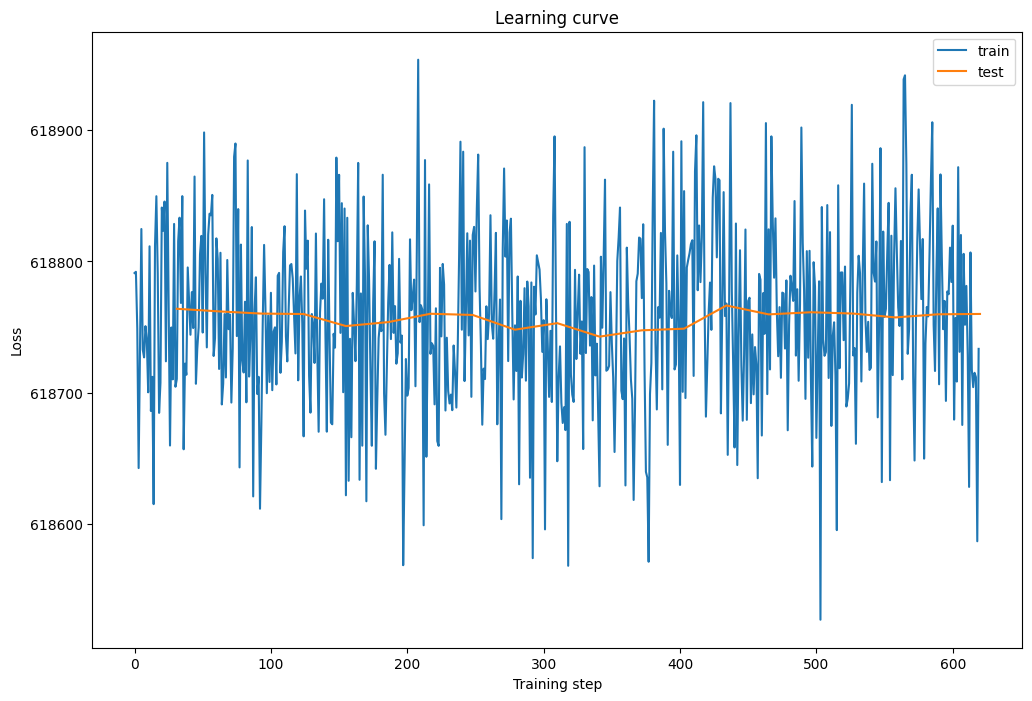

In [14]:
utils.show_learning_curve(train_metrics, test_metrics)

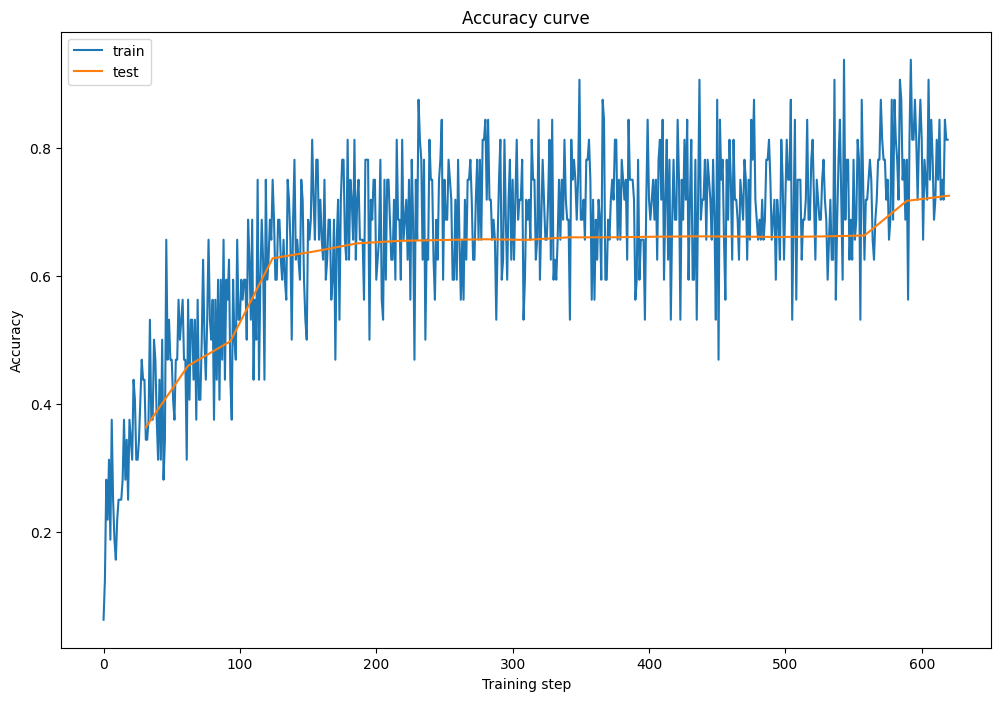

In [15]:
utils.show_accuracy_curve(train_metrics, test_metrics)

In [16]:
print(f"Best training accuracy: {max(train_metrics['acc'])}")
print(f"Best testing accuracy: {max(test_metrics['acc'])}")

Best training accuracy: 0.9375
Best testing accuracy: 0.7250999808311462


In [17]:
num_samplings = 10
analyzer = utils.Analyzer(model, test_dataset, num_samplings)

Top high confidence correct predictions


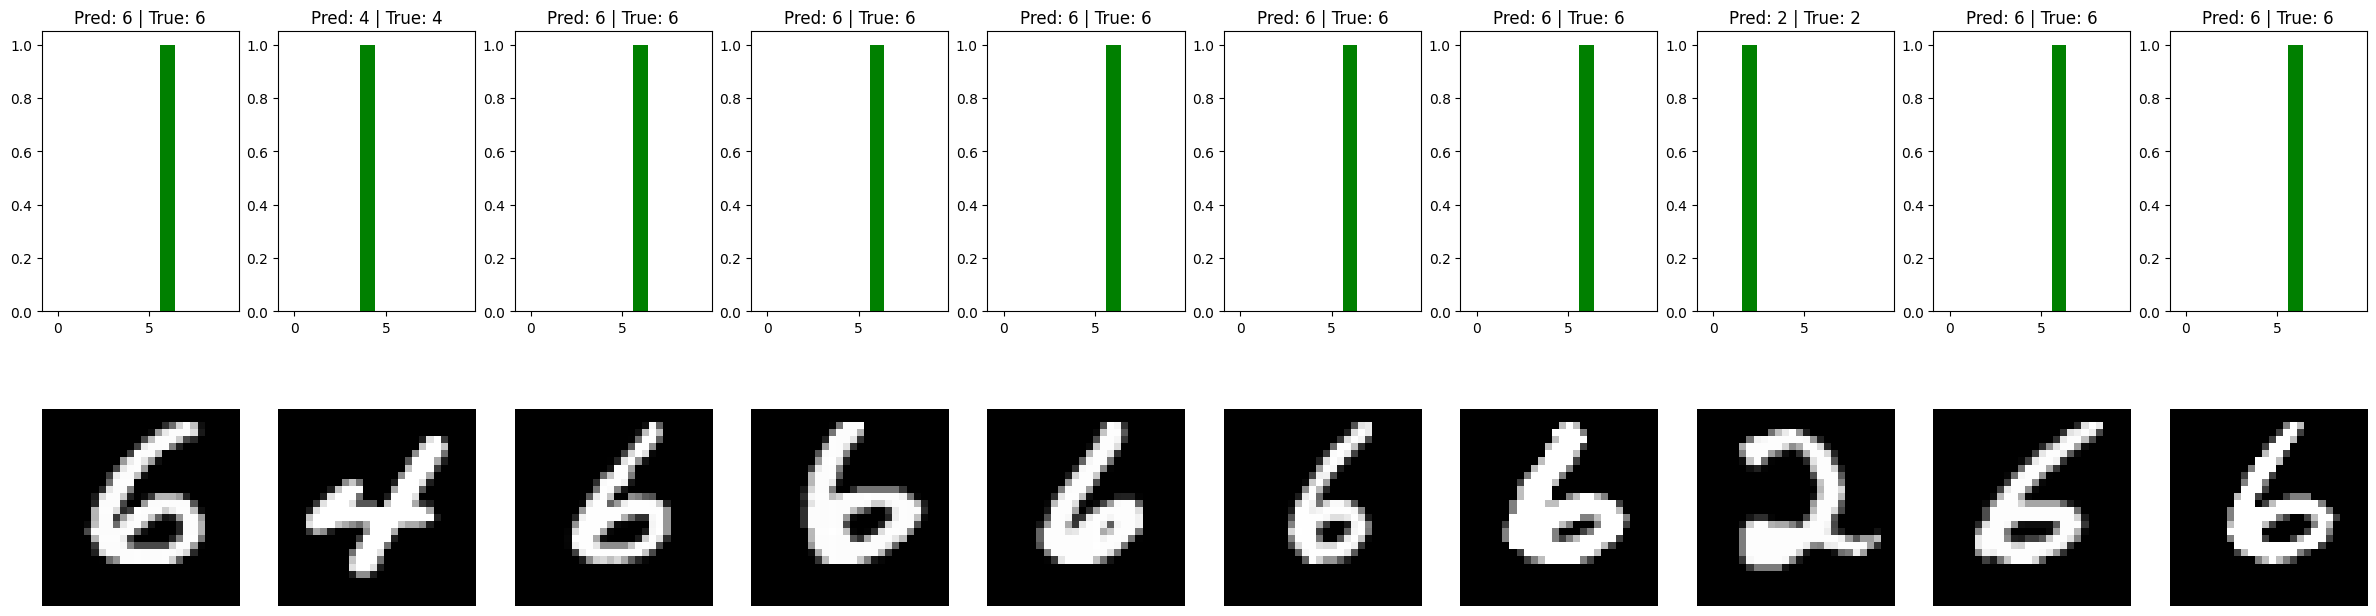

In [18]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_correct(10)
)
print("Top high confidence correct predictions")

Top low confidence correct predictions


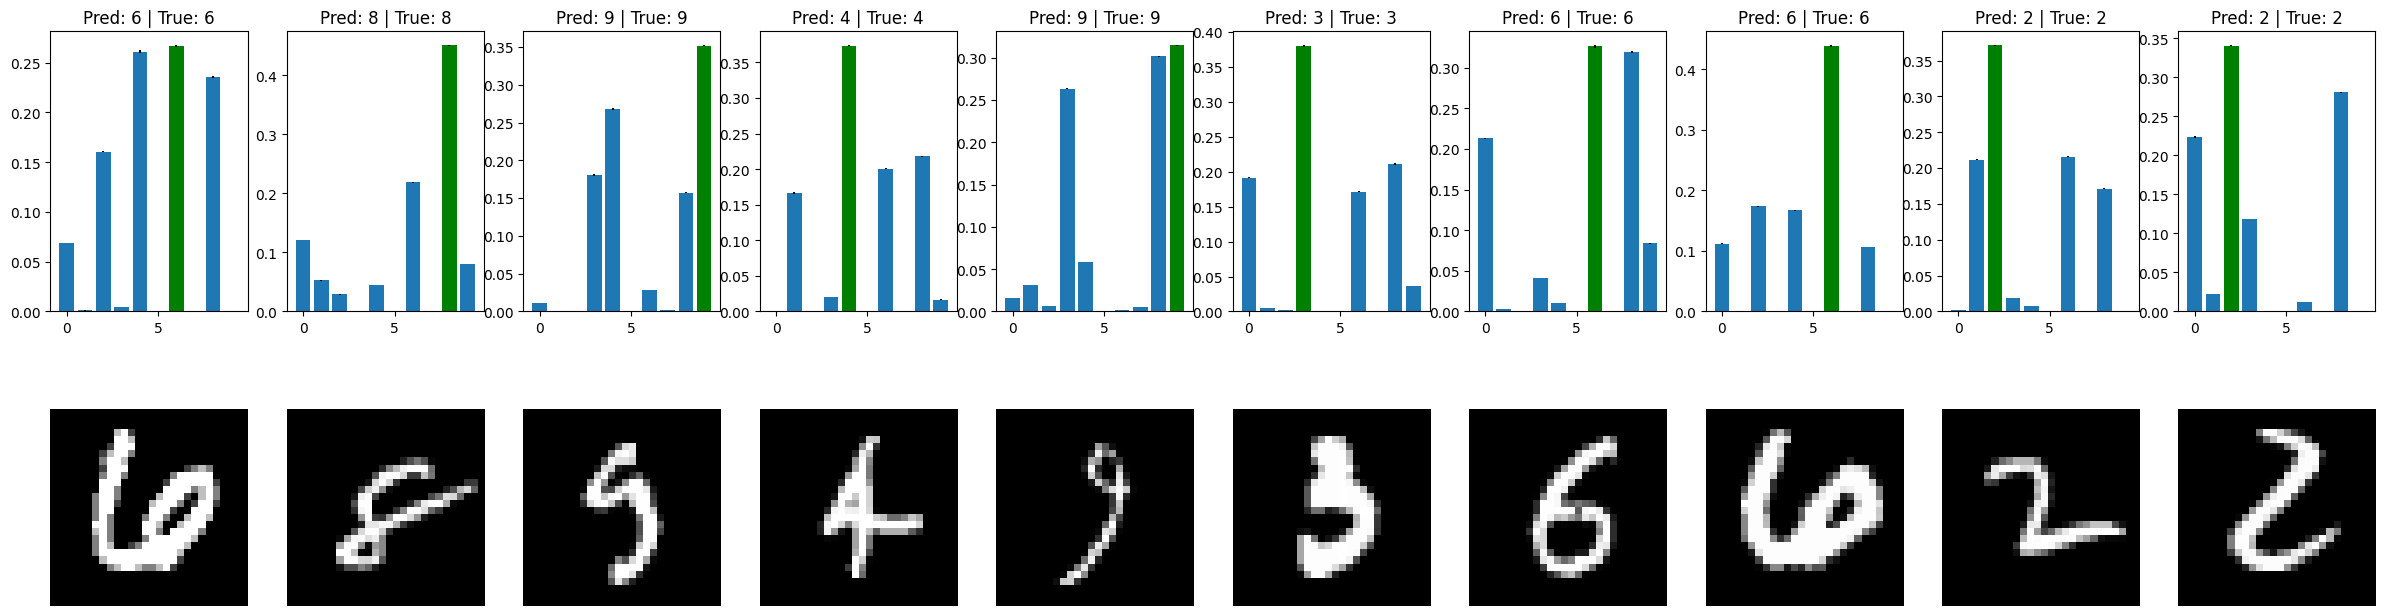

In [19]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_correct(10)
)
print("Top low confidence correct predictions")

Top low confidence wrong predictions


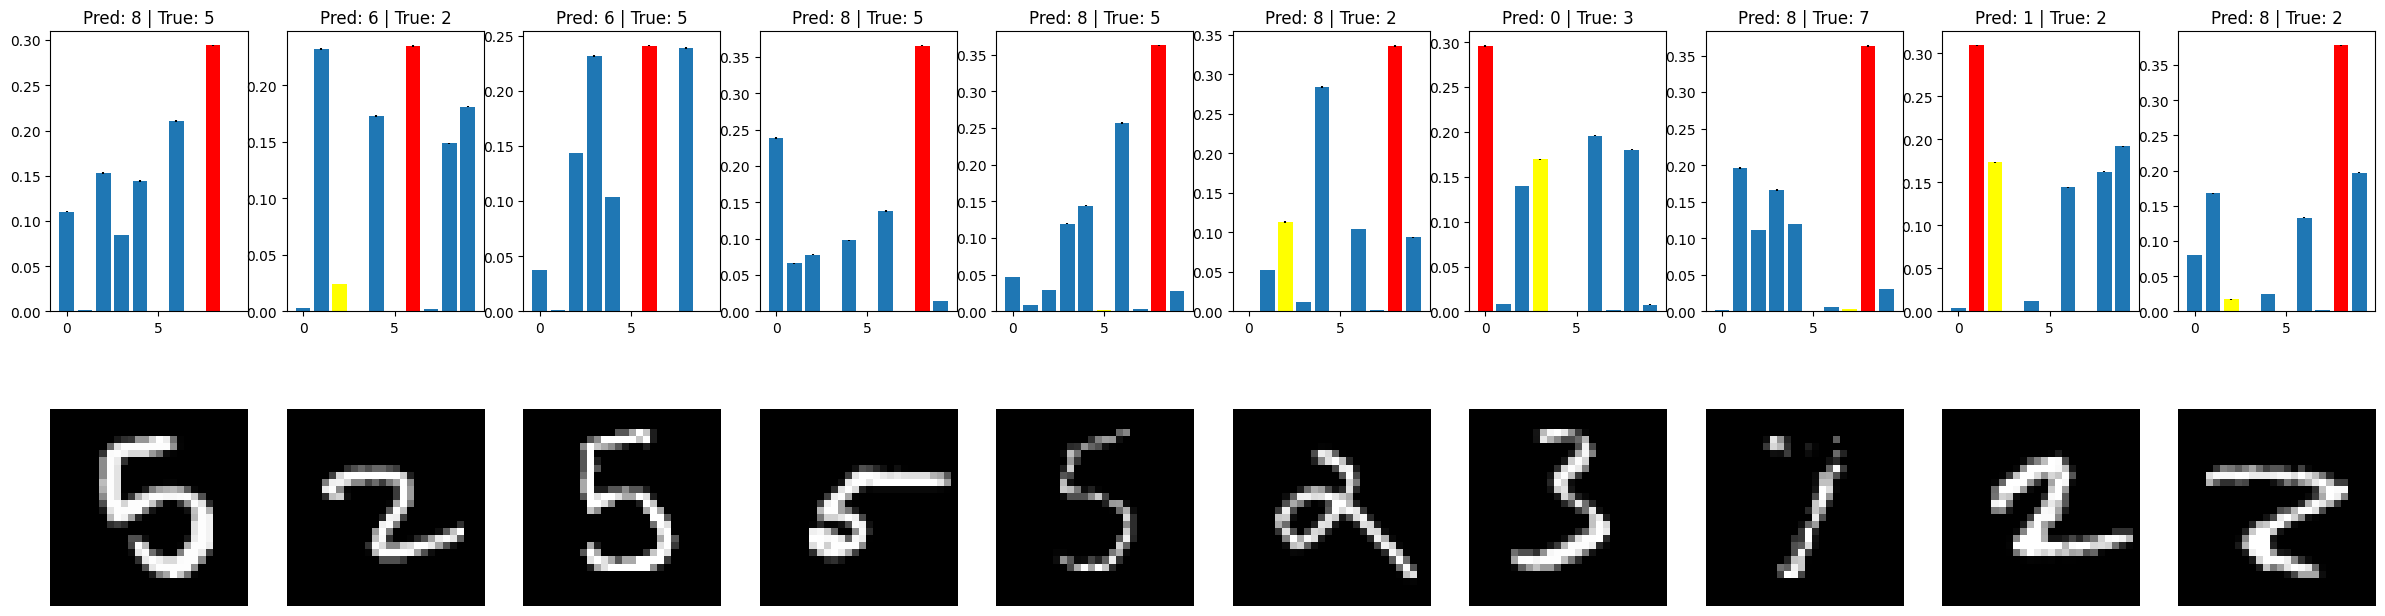

In [20]:
utils.visualize_samples(
    *analyzer.get_top_k_low_confidence_mistakes(10)
)

print("Top low confidence wrong predictions")

Top high confidence wrong predictions


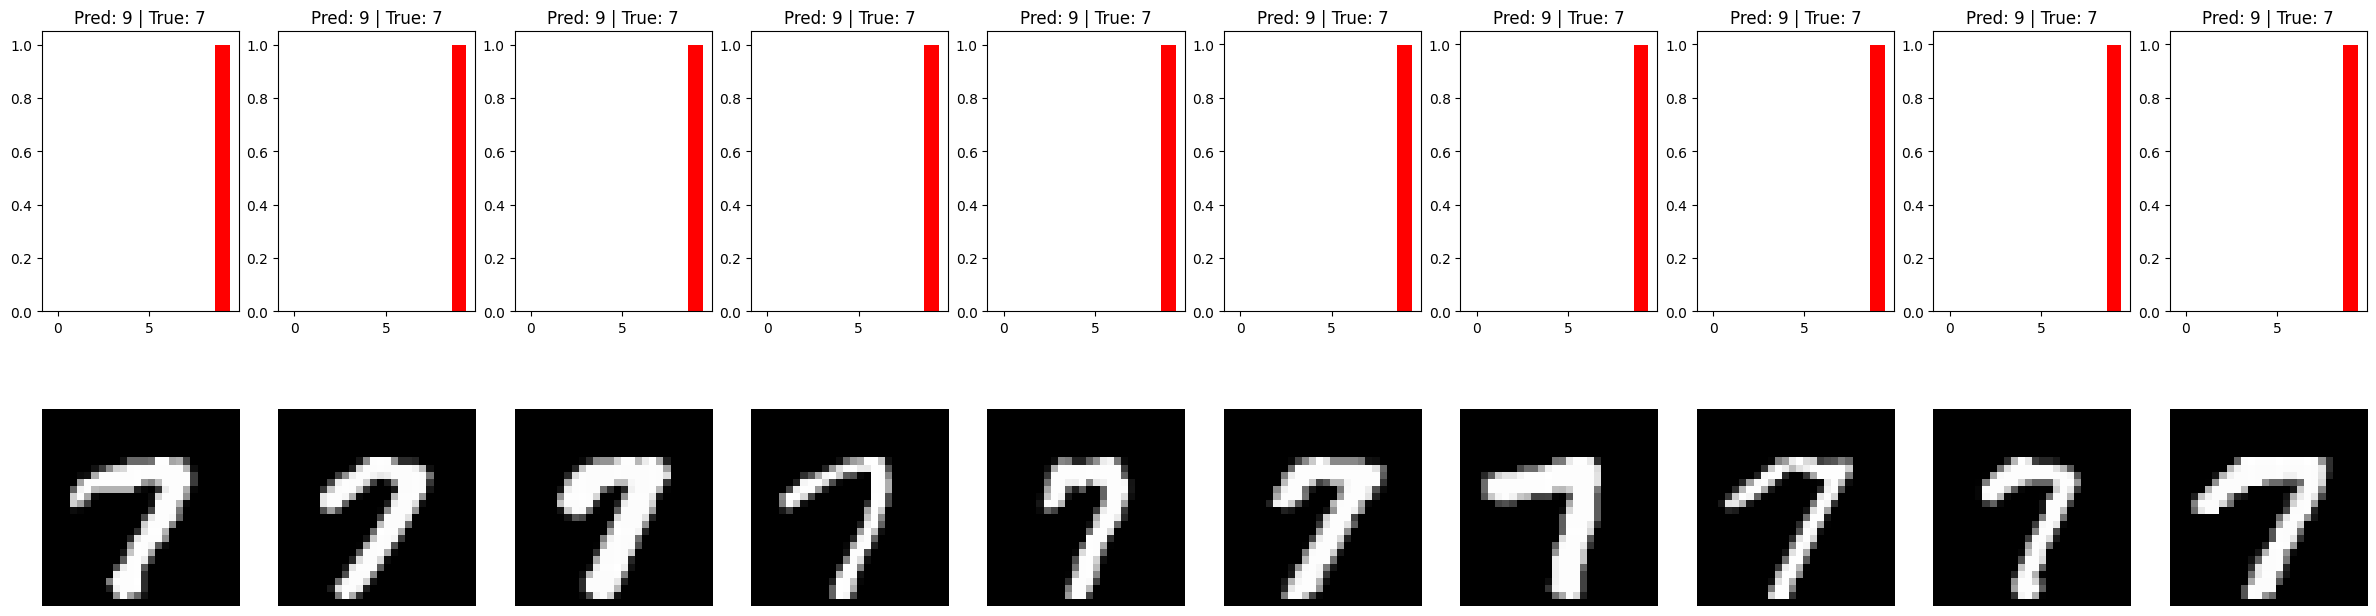

In [21]:
utils.visualize_samples(
    *analyzer.get_top_k_high_confidence_mistakes(10)
)

print("Top high confidence wrong predictions")

# Zadanie 3 (0.1 pkt)
Przypisz do zmiennych `layer_1_means` oraz `layer_2_means` wartości parametrów średnich rozkładu normalnego $\mu$ dla odpowiednio pierwszej i drugiej warstwy.

Histogram of weights for layer 1


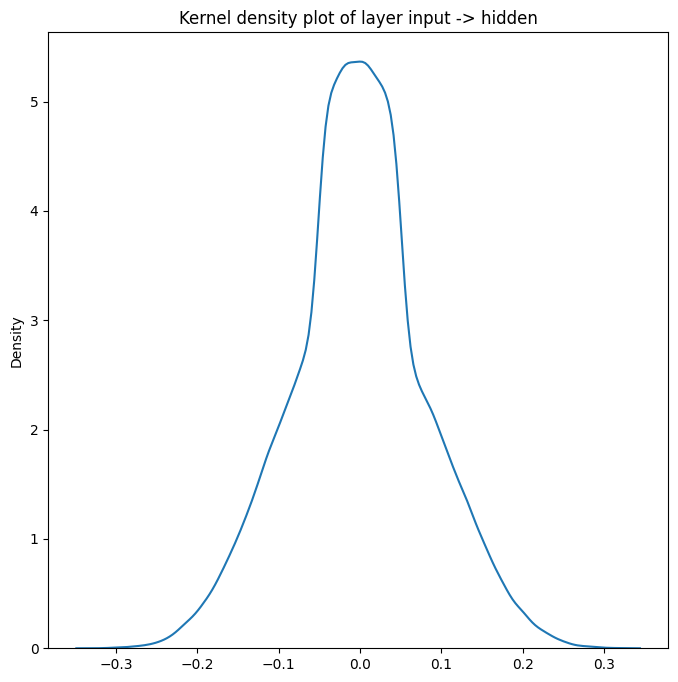

In [22]:
layer_1_means = model.layer_1.weight_mu.cpu()
utils.visualize_weights(layer_1_means, "layer input -> hidden")
print("Histogram of weights for layer 1")

Histogram of weights for layer 2


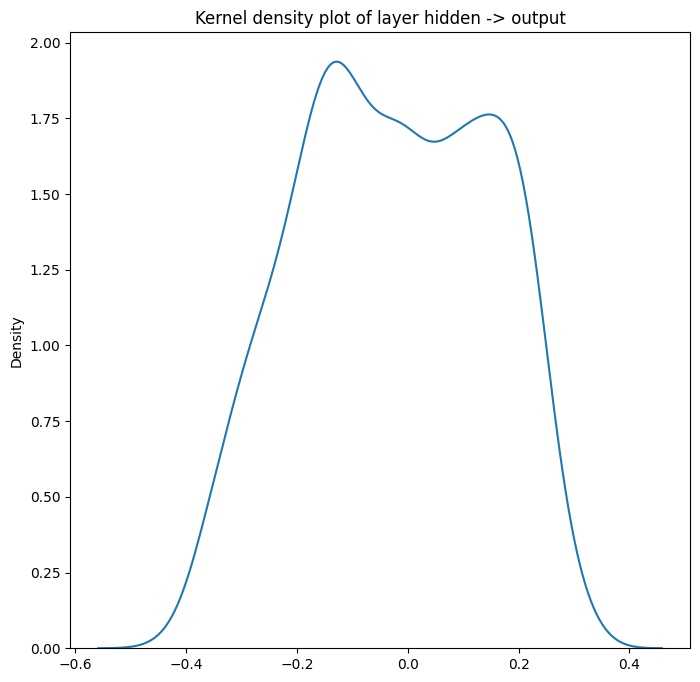

In [23]:
layer_2_means = model.layer_2.weight_mu.cpu()

utils.visualize_weights(layer_2_means, "layer hidden -> output")
print("Histogram of weights for layer 2")

# Zadanie 4 (1.4 pkt)
Zbadaj wpływ hiperparametrów na działanie modelu:
- parametry w rozkładzie prior (tzn. `sigma_1`, `sigma_2`, `mixing`)
- co się stanie jeśli zastosujemy tylko jeden rozkład normalny jako prior (zamiast mikstury)?
- rozmiar mini-paczki (`batch_size`)
- współczynnik uczenia (`learning_rate`)

In [24]:
class GaussianPrior:
    
    def __init__(self, sigma: float = 1):
        self.prior = torch.distributions.Normal(0, sigma)
        
    def log_prob(self, weights: torch.Tensor, biases: torch.Tensor):
        w_log_prior = self.prior.log_prob(weights)
        b_log_prior = self.prior.log_prob(biases)
        return w_log_prior.mean() + b_log_prior.mean()

def create_model(prior_on=True, sigma_1=1, sigma_2=1e-6, mixing=0.5):
    prior_layer_1 = TwoGaussianMixturePrior(sigma_1, sigma_2, mixing) if prior_on else GaussianPrior()
    prior_layer_2 = TwoGaussianMixturePrior(sigma_1, sigma_2, mixing) if prior_on else GaussianPrior()
    
    model = BayesianMLP(
        num_input_features=28 * 28,
        num_hidden_features=128,
        num_output_classes=10,
    )
    
    model.layer_1.prior = prior_layer_1
    model.layer_2.prior = prior_layer_2

    return model


def train_model_with_hyperparams(prior_on, sigma_1=1, sigma_2=1e-6, mixing=0.5, batch_size=32, lr=1e-3,):
    model = create_model(prior_on, sigma_1, sigma_2, mixing)
    
    loss_fun = ELBO(N=10)
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=lr,
    )
    
    train_metrics, test_metrics = utils.fit_elbo(
        model=model,
        train_dataset=train_dataset,
        valid_dataset=test_dataset,
        loss_function=loss_fun,
        batch_size=batch_size,
        epochs=20,
        optimizer=optimizer,
    )
    
    return model, train_metrics, test_metrics

In [27]:
import json

sigmas = [(1, 1e-6, 0.5), (0.5, 0.5e-6, 0.5), (0.25, 1e-6, 0.5), (1, 1e-6, 0.25), (0.5, 1e-6, 1)]
prior_on = [True, False]
best_hyperparams = {}
results = []

train_dataset, test_dataset = utils.load_mnist_datasets(limit_train_samples_to=1_000)

for use_prior in prior_on:
    for sigma_1, sigma_2, mixing in sigmas:
        model, train_metrics, test_metrics = train_model_with_hyperparams(use_prior, sigma_1, sigma_2, mixing)
        result = {
            'prior_on': use_prior,
            'sigma_1': sigma_1,
            'sigma_2': sigma_2,
            'mixing': mixing,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics
        }
        results.append(result)
                
with open('results.json', 'w') as file:
    json.dump(results, file)

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 1 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 2 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 3 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 4 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 5 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 6 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 7 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 8 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 9 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 10 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 11 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 12 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 13 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 14 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 15 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 16 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 17 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 18 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 19 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 20 / 20


  0%|          | 0/31 [00:00<?, ?it/s]

{'prior_on': True, 'sigma_1': 0.25, 'sigma_2': 1e-06, 'mixing': 0.5, 'train_metrics': {'loss': [618864.125, 618854.375, 618909.875, 618770.1875, 618869.875, 618959.8125, 618934.6875, 618863.875, 618945.6875, 618821.75, 618786.0, 618861.75, 618839.8125, 618825.5625, 618673.375, 618804.8125, 618829.625, 618772.875, 618790.875, 618888.4375, 618823.5, 618870.625, 618718.875, 618788.5, 618841.5625, 618828.0625, 618892.125, 618800.5, 618819.0625, 618811.125, 618865.1875, 619013.375, 618865.4375, 618872.5625, 618843.75, 618772.625, 618775.125, 618762.3125, 618943.125, 618832.625, 618906.4375, 618899.3125, 618906.75, 618806.125, 618757.25, 618896.875, 618856.6875, 618829.875, 618750.3125, 618772.125, 618936.1875, 618930.0625, 618820.5625, 618887.1875, 618814.375, 618864.375, 618849.5625, 618943.25, 618763.1875, 618851.5, 618912.9375, 618847.6875, 618770.1875, 618884.875, 618838.3125, 618813.125, 618933.6875, 618810.0625, 618796.8125, 618884.5625, 618819.0625, 618843.5625, 618672.3125, 618887.3

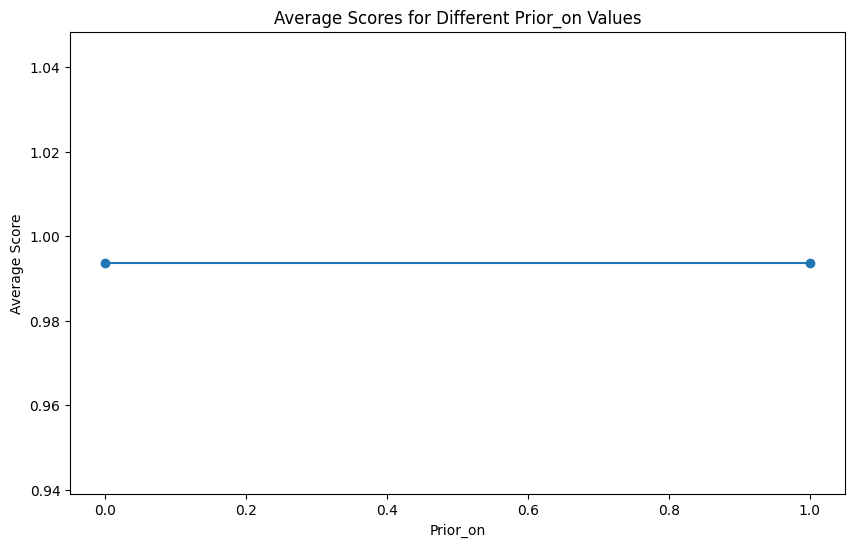

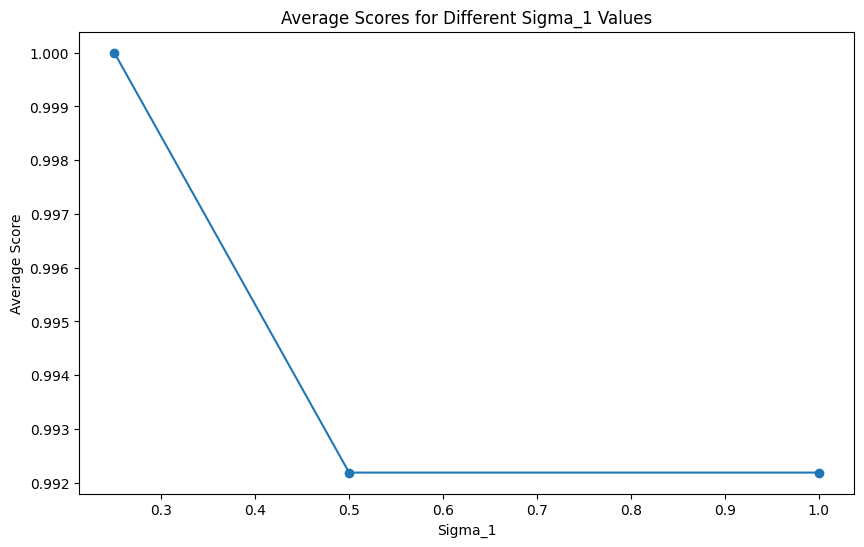

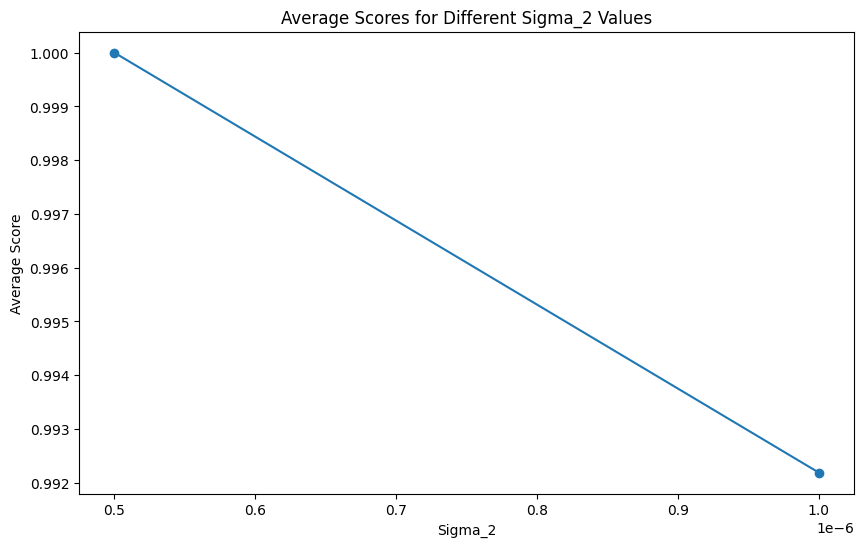

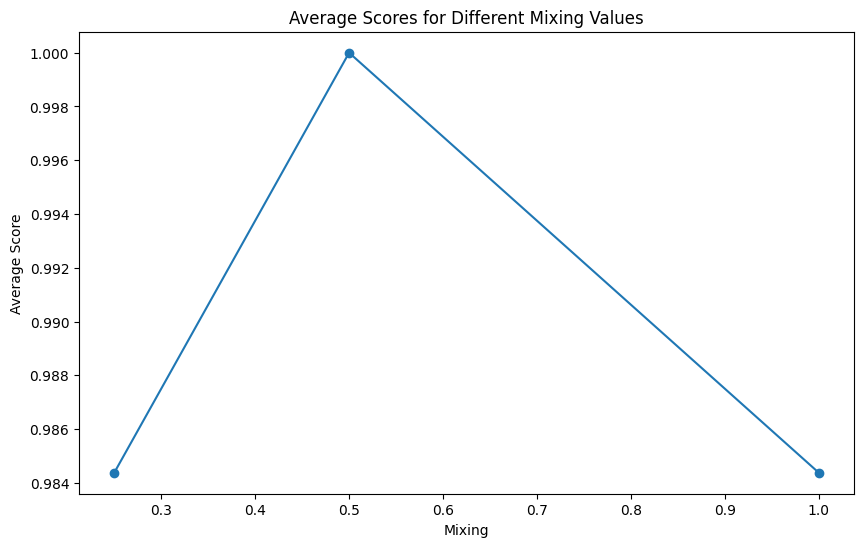

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

with open('results.json', 'r') as file:
    results = json.load(file)
    
best_acc = -float('inf')
best_params = None 
for params in results:
    train_acc = params['train_metrics']['acc']
    if train_acc and train_acc[-1] > best_acc:
        best_acc = train_acc[-1]
        best_params = params
        
print(best_params)

df = pd.DataFrame(results)
df['max_train_acc'] = df['train_metrics'].apply(lambda x: max(x['acc']))
df['max_train_loss'] = df['train_metrics'].apply(lambda x: max(x['loss']))
df['max_test_acc'] = df['test_metrics'].apply(lambda x: max(x['acc']))
df['max_test_loss'] = df['test_metrics'].apply(lambda x: max(x['loss']))

def get_average_for(result: pd.DataFrame, param: str):
    avg_scores = result.groupby(param)['max_train_acc'].mean()
    avg_scores_df = avg_scores.reset_index()
    avg_scores_df.columns = [param, 'max_train_acc']
    return avg_scores_df

def plot_avg_scores(result: pd.DataFrame, param: str):
    avg_scores = get_average_for(result, param)
    plt.figure(figsize=(10, 6))
    plt.plot(avg_scores[param], avg_scores['max_train_acc'], marker='o', linestyle='-')
    plt.xlabel(param.capitalize())
    plt.ylabel('Average Score')
    plt.title(f'Average Scores for Different {param.capitalize()} Values')
    plt.show()

def plot_all_avg_scores(result: pd.DataFrame):
    plot_avg_scores(result, 'prior_on')
    plot_avg_scores(result, 'sigma_1')
    plot_avg_scores(result, 'sigma_2')
    plot_avg_scores(result, 'mixing')  
    
plot_all_avg_scores(df)